# Interpolation network

Created: 2019-01-04

Data generated from: [2019-01-03 - Preprocess data for sparse coding](http://130.140.51.184:8888/notebooks/sparse_coding/2019-01-03%20-%20Preprocess%20data%20for%20sparse%20coding.ipynb)

# Methods

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 72

# green, red, blue, yellow, purple, blue, grey
flatui = ["#2DEC2A","#F6204F","#33CCFF","#FFCC33","#9b59b6","#25BCFE","#95a5a6"]
default_colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF","#F9AE23"]

def fontsize(ax, fz = 14):
    """Set all fontsizes to fz"""
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fz)

def labels(ax, title=None, subtitle=None, xlabel=None, ylabel=None, xticklabels = None, legend_title = None, legend_labels=None, legend_loc = 'upper right', fz=14, grid=True):
    """Assign titles and labels.
    xticklabels and legend_labels should be lists, all others are strings."""
    if title is not None:
        if subtitle is None:
            plt.title(title)
        else:
            plt.suptitle(title, y=1, fontsize=fz+2)
            plt.title(subtitle)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if legend_title is not None and legend_labels is not None:
        handles, ax_legend_labs = ax.get_legend_handles_labels()
        ax.legend(handles, legend_labels, title=legend_title, loc=legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel);
    if ylabel is not None:
        plt.ylabel(ylabel);
    if grid:
        plt.grid(linestyle='dotted')
    fontsize(ax, fz)

def annotate(ax, x, y, text, offset=5):
    """Place text in different locations of the plot.
    x and y are lists of locations on the plot. text can be a list of numbers or strings."""
    for i in range(len(x)):
        ax.text(x[i], y[i]+offset, text[i], bbox={'facecolor':'white','pad':5}, horizontalalignment='center')

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Load data

In [1]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [7]:
X = np.load('/local/home/Asif/data/tmp/ards_hr.npy')

In [2]:
data = np.load('/local/home/Asif/data/tmp/ards_hr_gpinterp.npy')

In [4]:
data.shape

(70715, 48, 1)

# RBF Network

In [9]:
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import chain
from functools import partial
import torch.nn.functional as F

In [10]:
class RbfNet(nn.Module):
    def __init__(self, centers, num_class=10):
        super(RbfNet, self).__init__()
        self.num_class = num_class
        self.num_centers = centers.size(0)

        self.centers = nn.Parameter(centers)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)/10)
        self.linear = nn.Linear(self.num_centers, self.num_class, bias=True)
        utils.initialize_weights(self)

    def kernel_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)
        C = torch.exp(-self.beta.mul((A-B).pow(2).sum(2,keepdim=False).sqrt() ) )
        return C

    def forward(self, batches):
        radial_val = self.kernel_fun(batches)
        class_score = self.linear(radial_val)
        return class_score

In [11]:
class Learner:
    def __init__(self, model, optimizer, lossfun, step_size=0.01, device='cpu', cyclic=True):
        self.model = model.to(device)
        self.optimizer = optimizer(self.model.parameters())
        if cyclic:
            self.scheduler = CyclicLR(self.optimizer)
        self.lossfun = lossfun
        self.device = device
        self.cyclic = cyclic
        self.loss_history = []
        self.learn_rates = []

    def fit(self, x, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                if self.cyclic:
                    self.scheduler.batch_step()
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(x[idx : min(idx + batch_size, x.shape[0]), :, 0]).float().to(self.device).requires_grad_(False)
                encoded, decoded = self.model(batch_x)
                loss = self.lossfun(encoded, decoded, batch_x, batch_size, self.model.param)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            self.learn_rates.append(self.optimizer.param_groups[0]['lr'])
            if (e+1) % 1 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))

    def predict(self, x, train=False):
        if train:
            self.model.train()
        else:
            self.model.eval()
        return [_.cpu().detach().numpy() for _ in self.model(torch.from_numpy(x).float().to(self.device).requires_grad_(False))]

In [79]:
def kernel(rk, tj):
    return np.exp(-alpha * np.sqrt(np.sum(np.square(rk - tj))))

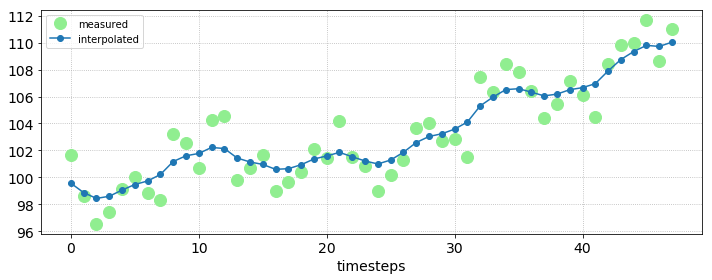

In [166]:
L = 48 # observerd timesteps
T = 48 # reference timesteps
r = np.arange(T)

i = 40

x = X[i,:]
m = np.isfinite(x)
t = r[m]
x = x[m]

alpha = 0.5

xh = np.zeros(T)
for k in range(T):
    rk = r[k]
    w = np.array([kernel(rk, tj) for tj in t])
    xh[k] = np.sum(w * x) / np.sum(w)

plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
plt.plot(t,x,'o', color='lightgreen', ms=12, label='measured')
plt.plot(r,xh,'o-', label='interpolated')
labels(ax, xlabel='timesteps')
plt.legend()
plt.tight_layout()